In [1]:
import pandas as pd
from datetime import datetime
import re
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.decomposition import PCA

In [2]:
import pandas as pd

# Define the file path
file_path = '/Users/bneepunkumar/Downloads/merge-csv.com__66b26c77ca945.csv'



# Read the CSV file, skipping the first two rows, and setting column names explicitly
data = pd.read_csv(file_path, skiprows=3, names=['Timestamp', 'TrafficCount'])

# Display the first few rows of the dataset to verify
print(data.head())

# Convert the 'Timestamp' column to datetime
data['Timestamp'] = pd.to_datetime(data['Timestamp'], format='%Y-%m-%d %H:%M:%S', errors='coerce')

# Drop rows with invalid datetime values
data = data.dropna(subset=['Timestamp'])


# Set 'Timestamp' as the index
data.set_index('Timestamp', inplace=True)

# Display the first few rows to verify
print(data.index)

# Now you can proceed with your analysis


             Timestamp  TrafficCount
0            Timestamp  TrafficCount
1  2020-01-20 00:00:00        487.00
2  2020-01-20 00:30:00        385.00
3  2020-01-20 01:30:00        269.00
4  2020-01-20 02:30:00        517.00
DatetimeIndex(['2020-01-20 00:00:00', '2020-01-20 00:30:00',
               '2020-01-20 01:30:00', '2020-01-20 02:30:00',
               '2020-01-20 03:30:00', '2020-01-20 04:30:00',
               '2020-01-20 05:30:00', '2020-01-20 06:30:00',
               '2020-01-20 07:30:00', '2020-01-20 08:30:00',
               ...
               '2020-05-24 14:30:00', '2020-05-24 15:30:00',
               '2020-05-24 16:30:00', '2020-05-24 17:30:00',
               '2020-05-24 18:30:00', '2020-05-24 19:30:00',
               '2020-05-24 20:30:00', '2020-05-24 21:30:00',
               '2020-05-24 22:30:00', '2020-05-24 23:30:00'],
              dtype='datetime64[ns]', name='Timestamp', length=11266, freq=None)


In [3]:

# Get the total number of rows
total_rows = data.shape[0]
print(f'Total number of rows: {total_rows}')

Total number of rows: 11266


In [4]:
data.head()

,TrafficCount
Timestamp,
2020-01-20 00:00:00,487.00
2020-01-20 00:30:00,385.00
2020-01-20 01:30:00,269.00
2020-01-20 02:30:00,517.00
2020-01-20 03:30:00,129.00


In [5]:
print("Columns in the dataset:", data.columns)



Columns in the dataset: Index(['TrafficCount'], dtype='object')


In [6]:
data['TrafficCount'] = pd.to_numeric(data['TrafficCount'], errors='coerce')


In [7]:
# Check for any missing or NaN values
print(data.isna().sum())

# Check the data types of each column
print(data.dtypes)

# Display a summary of the dataframe
print(data.describe())

TrafficCount    0
dtype: int64
TrafficCount    float64
dtype: object
       TrafficCount
count  11266.000000
mean    3774.445944
std     7309.435377
min        1.000000
25%       70.000000
50%      676.500000
75%     3182.000000
max    71925.000000


In [8]:
print(data.index)


DatetimeIndex(['2020-01-20 00:00:00', '2020-01-20 00:30:00',
               '2020-01-20 01:30:00', '2020-01-20 02:30:00',
               '2020-01-20 03:30:00', '2020-01-20 04:30:00',
               '2020-01-20 05:30:00', '2020-01-20 06:30:00',
               '2020-01-20 07:30:00', '2020-01-20 08:30:00',
               ...
               '2020-05-24 14:30:00', '2020-05-24 15:30:00',
               '2020-05-24 16:30:00', '2020-05-24 17:30:00',
               '2020-05-24 18:30:00', '2020-05-24 19:30:00',
               '2020-05-24 20:30:00', '2020-05-24 21:30:00',
               '2020-05-24 22:30:00', '2020-05-24 23:30:00'],
              dtype='datetime64[ns]', name='Timestamp', length=11266, freq=None)


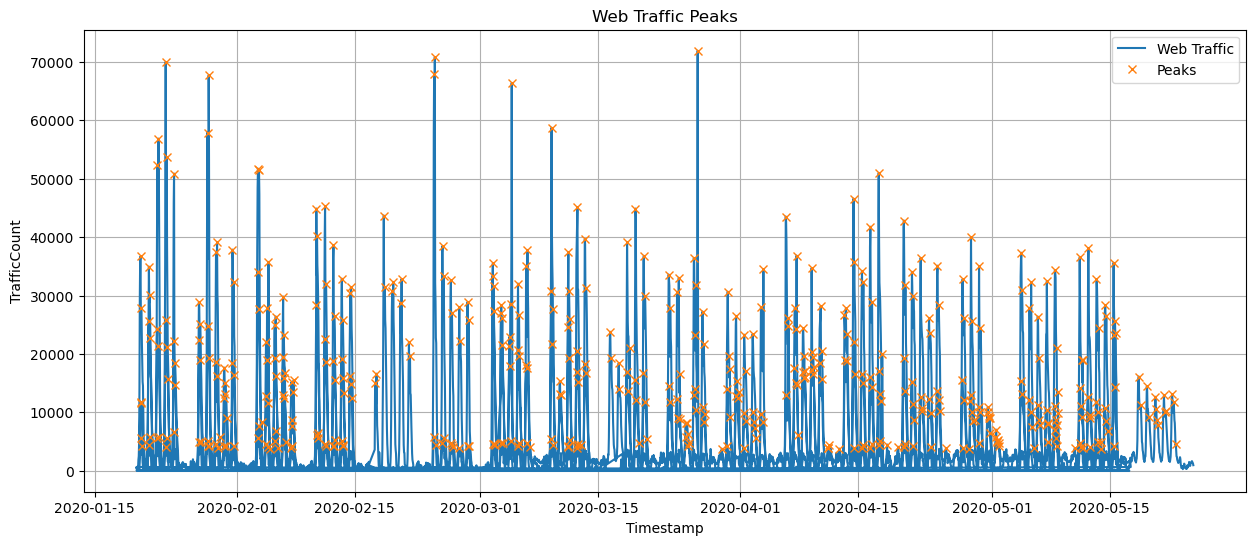

In [9]:
from scipy.signal import find_peaks
import matplotlib.pyplot as plt

# Detect peaks in traffic
peaks, _ = find_peaks(data['TrafficCount'], height=data['TrafficCount'].mean())
plt.figure(figsize=(15, 6))
plt.plot(data.index, data['TrafficCount'], label='Web Traffic')
plt.plot(data.index[peaks], data['TrafficCount'][peaks], 'x', label='Peaks')
plt.title('Web Traffic Peaks')
plt.xlabel('Timestamp')
plt.ylabel('TrafficCount')
plt.legend()
plt.grid(True)
plt.show()

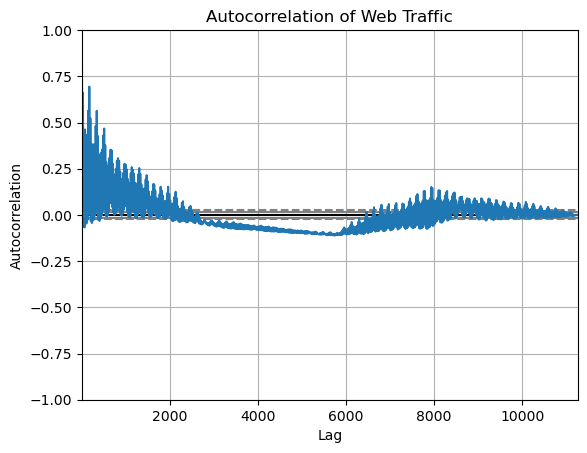

In [10]:
# Autocorrelation plot
pd.plotting.autocorrelation_plot(data['TrafficCount'])
plt.title('Autocorrelation of Web Traffic')
plt.show()

In [ ]:
print("Columns in the dataset:", data.columns)

# Check if 'Timestamp' is the correct column name
if 'Timestamp' in data.columns:
    timestamp_column = 'Timestamp'
elif 'timestamp' in data.columns:
    timestamp_column = 'timestamp'
else:
    raise KeyError("Timestamp column not found in the dataset")

# Convert the timestamp column to datetime if it's not already
data[timestamp_column] = pd.to_datetime(data[timestamp_column])

# Check the date range of the dataset
start_date = data[timestamp_column].min()
end_date = data[timestamp_column].max()

print(f'The dataset starts from: {start_date}')
print(f'The dataset ends on: {end_date}')
print(f'Total duration: {end_date - start_date}')

# Set 'Timestamp' as the index
data.set_index(timestamp_column, inplace=True)

In [11]:
#Step 2: Define the Dataset and DataLoader
import torch
from torch.utils.data import Dataset, DataLoader

class TimeSeriesDataset(Dataset):
    def __init__(self, data, sequence_length):
        self.data = data
        self.sequence_length = sequence_length

    def __len__(self):
        return len(self.data) - self.sequence_length

    def __getitem__(self, idx):
        x = self.data[idx:idx + self.sequence_length]
        y = self.data[idx + self.sequence_length]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

# Convert the data to numpy array
data_array = data['TrafficCount'].values

# Define the sequence length
sequence_length = 10

# # Create dataset and dataloader
# dataset = TimeSeriesDataset(data_array, sequence_length)
# dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [12]:
# Split the data into training (70%), validation (15%), and testing sets (15%)
train_size = int(len(data_array) * 0.7)
val_size = int(len(data_array) * 0.15)
test_size = len(data_array) - train_size - val_size

train_data = data_array[:train_size]
val_data = data_array[train_size:train_size + val_size]
test_data = data_array[train_size + val_size:]

# Normalize the dataset (fit on train data only)
scaler = StandardScaler()
train_data = scaler.fit_transform(train_data.reshape(-1, 1)).flatten()
val_data = scaler.transform(val_data.reshape(-1, 1)).flatten()
test_data = scaler.transform(test_data.reshape(-1, 1)).flatten()

# Create datasets and dataloaders for each set
train_dataset = TimeSeriesDataset(train_data, sequence_length)
val_dataset = TimeSeriesDataset(val_data, sequence_length)
test_dataset = TimeSeriesDataset(test_data, sequence_length)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)


### Transformer model

In [13]:
# Define the Transformer Model class
class TransformerModel(nn.Module):
    def __init__(self, input_dim, model_dim, nhead, num_encoder_layers, num_decoder_layers, dim_feedforward, dropout=0.1):
        super(TransformerModel, self).__init__()
        self.model_dim = model_dim
        self.embedding = nn.Linear(input_dim, model_dim)
        self.positional_encoding = nn.Parameter(torch.zeros(1, 5000, model_dim))  # Max sequence length of 5000
        self.transformer = nn.Transformer(
            d_model=model_dim,
            nhead=nhead,
            num_encoder_layers=num_encoder_layers,
            num_decoder_layers=num_decoder_layers,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
        )
        self.fc = nn.Linear(model_dim, 1)
        self.dropout = nn.Dropout(dropout)

    def forward(self, src, tgt):
        src = self.embedding(src) + self.positional_encoding[:, :src.size(1), :]
        tgt = self.embedding(tgt) + self.positional_encoding[:, :tgt.size(1), :]
        src = self.dropout(src)
        tgt = self.dropout(tgt)
        output = self.transformer(src, tgt)
        output = self.fc(output)
        return output

# Initialize model parameters
input_dim = 1
model_dim = 64
nhead = 4
num_encoder_layers = 4
num_decoder_layers = 4
dim_feedforward = 128
dropout = 0.1

model = TransformerModel(input_dim, model_dim, nhead, num_encoder_layers, num_decoder_layers, dim_feedforward, dropout)

num_epochs = 5
learning_rate = 0.001

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for x, y in train_dataloader:
        x = x.unsqueeze(-1).permute(1, 0, 2)  # Add a dimension for input features and permute for transformer
        y_input = x[:-1, :, :]  # Use input sequences excluding the last element for the target input
        y_target = x[1:, :, :]  # Use input sequences excluding the first element for the target output

        optimizer.zero_grad()
        output = model(x, y_input)
        loss = criterion(output.reshape(-1), y_target.reshape(-1))
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_dataloader)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for x, y in val_dataloader:
            x = x.unsqueeze(-1).permute(1, 0, 2)  # Add a dimension for input features and permute for transformer
            y_input = x[:-1, :, :]  # Use input sequences excluding the last element for the target input
            y_target = x[1:, :, :]  # Use input sequences excluding the first element for the target output

            output = model(x, y_input)
            loss = criterion(output.reshape(-1), y_target.reshape(-1))

            val_loss += loss.item()

    val_loss /= len(val_dataloader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')
    # Save the trained model
    torch.save(model.state_dict(), 'transformer_model.pth')


/Users/bneepunkumar/anaconda3/lib/python3.11/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/5], Train Loss: 0.1943, Validation Loss: 0.0724
Epoch [2/5], Train Loss: 0.1053, Validation Loss: 0.0595
Epoch [3/5], Train Loss: 0.0991, Validation Loss: 0.0623
Epoch [4/5], Train Loss: 0.0979, Validation Loss: 0.0599
Epoch [5/5], Train Loss: 0.0943, Validation Loss: 0.0599


Test Loss: 0.0555
Length of test_datetimes: 1681
Length of test_targets_original: 1681
Length of test_predictions_original: 1681
Adjusted length of test_datetimes: 1681


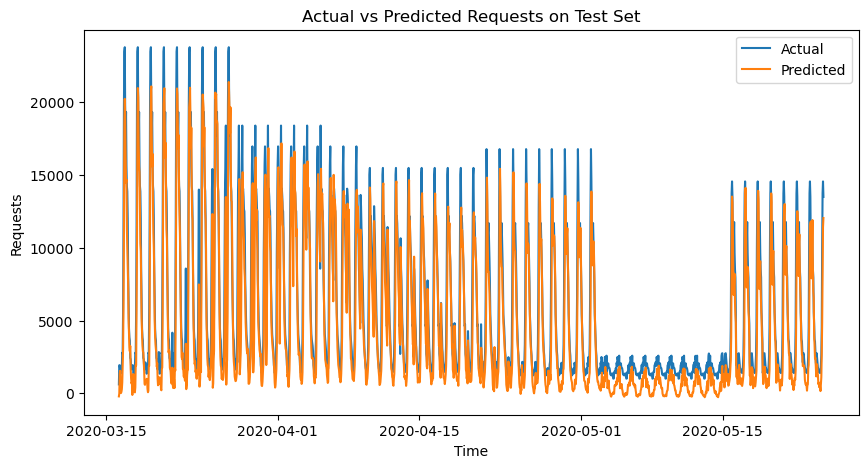

In [14]:
# Evaluate the model on the test data
model.eval()
test_loss = 0.0
test_predictions = []
test_targets = []
with torch.no_grad():
    for x, y in test_dataloader:
        x = x.unsqueeze(-1).permute(1, 0, 2)  # Add a dimension for input features and permute for transformer
        y_input = x[:-1, :, :]  # Use input sequences excluding the last element for the target input
        y_target = x[1:, :, :]  # Use input sequences excluding the first element for the target output

        output = model(x, y_input)
        loss = criterion(output.reshape(-1), y_target.reshape(-1))
        test_loss += loss.item()

        test_predictions.append(output.reshape(-1).cpu().numpy())
        test_targets.append(y_target.reshape(-1).cpu().numpy())

test_loss /= len(test_dataloader)
print(f'Test Loss: {test_loss:.4f}')

# Concatenate predictions and targets
test_predictions = np.concatenate(test_predictions)
test_targets = np.concatenate(test_targets)

# Convert predictions and targets back to original scale
test_predictions_original = scaler.inverse_transform(test_predictions.reshape(-1, 1)).flatten()
test_targets_original = scaler.inverse_transform(test_targets.reshape(-1, 1)).flatten()

data.reset_index(inplace=True)

# Store datetime values corresponding to test data
test_datetimes = data['Timestamp'].values[train_size + val_size + sequence_length:]
# Ensure the datetime index matches the length of the test set
adjusted_length = min(len(test_datetimes), len(test_targets_original))
adjusted_test_datetimes = test_datetimes[:adjusted_length]


# Truncate targets and predictions to match datetime length
test_targets_original = test_targets_original[:len(adjusted_test_datetimes)]
test_predictions_original = test_predictions_original[:len(adjusted_test_datetimes)]

# Debugging output for lengths
print(f"Length of test_datetimes: {len(test_datetimes)}")
print(f"Length of test_targets_original: {len(test_targets_original)}")
print(f"Length of test_predictions_original: {len(test_predictions_original)}")
print(f"Adjusted length of test_datetimes: {len(adjusted_test_datetimes)}")

# Plot the test results with datetime values
plt.figure(figsize=(10, 5))
plt.plot(adjusted_test_datetimes, test_targets_original, label='Actual')
plt.plot(adjusted_test_datetimes, test_predictions_original, label='Predicted')
plt.xlabel('Time')
plt.ylabel('Requests')
plt.title('Actual vs Predicted Requests on Test Set')
plt.legend()
plt.show()


In [15]:
from sklearn.metrics import mean_squared_error, r2_score

mse = mean_squared_error(test_targets, test_predictions)
print(f'Mean Squared Error (MSE): {mse:.4f}')

# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error (RMSE): {rmse:.4f}')

# R-squared (R²)
r2 = r2_score(test_targets, test_predictions)
print(f'R-squared (R²): {r2:.4f}')

Mean Squared Error (MSE): 0.0557
Root Mean Squared Error (RMSE): 0.2361
R-squared (R²): 0.8303


### LSTM model

In [16]:
import numpy as np

class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim, dropout=0.2):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        self.activation = nn.Sigmoid()

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        lstm_out = self.dropout(lstm_out[:, -1, :])  # Get the last output of the sequence
        out = self.fc(lstm_out)
        out = self.activation(out)
        return out

# Initialize model parameters
input_dim = 1
hidden_dim = 20
num_layers = 2
output_dim = 1
dropout = 0.2

model = LSTMModel(input_dim, hidden_dim, num_layers, output_dim, dropout)

# Training configurations
num_epochs = 20
learning_rate = 0.001

criterion = nn.MSELoss()
optimizer = optim.RMSprop(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for x, y in train_dataloader:
        x = x.unsqueeze(-1)  # Add a dimension for input features
        y = y.unsqueeze(-1)  # Add a dimension for output features

        optimizer.zero_grad()
        output = model(x)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_dataloader)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for x, y in val_dataloader:
            x = x.unsqueeze(-1)  # Add a dimension for input features
            y = y.unsqueeze(-1)  # Add a dimension for output features

            output = model(x)
            loss = criterion(output, y)

            val_loss += loss.item()

    val_loss /= len(val_dataloader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')




Epoch [1/20], Train Loss: 0.7107, Validation Loss: 0.3032
Epoch [2/20], Train Loss: 0.5831, Validation Loss: 0.2863
Epoch [3/20], Train Loss: 0.5673, Validation Loss: 0.2785
Epoch [4/20], Train Loss: 0.5628, Validation Loss: 0.2733
Epoch [5/20], Train Loss: 0.5596, Validation Loss: 0.2741
Epoch [6/20], Train Loss: 0.5571, Validation Loss: 0.2756
Epoch [7/20], Train Loss: 0.5567, Validation Loss: 0.2706
Epoch [8/20], Train Loss: 0.5565, Validation Loss: 0.2713
Epoch [9/20], Train Loss: 0.5560, Validation Loss: 0.2710
Epoch [10/20], Train Loss: 0.5553, Validation Loss: 0.2720
Epoch [11/20], Train Loss: 0.5557, Validation Loss: 0.2714
Epoch [12/20], Train Loss: 0.5548, Validation Loss: 0.2719
Epoch [13/20], Train Loss: 0.5594, Validation Loss: 0.2712
Epoch [14/20], Train Loss: 0.5553, Validation Loss: 0.2716
Epoch [15/20], Train Loss: 0.5585, Validation Loss: 0.2715
Epoch [16/20], Train Loss: 0.5545, Validation Loss: 0.2715
Epoch [17/20], Train Loss: 0.5542, Validation Loss: 0.2698
Epoch 

Test Loss: 0.0692
Length of test_datetimes: 1681
Length of test_targets_original: 1681
Length of test_predictions_original: 1681
Adjusted length of test_datetimes: 1681


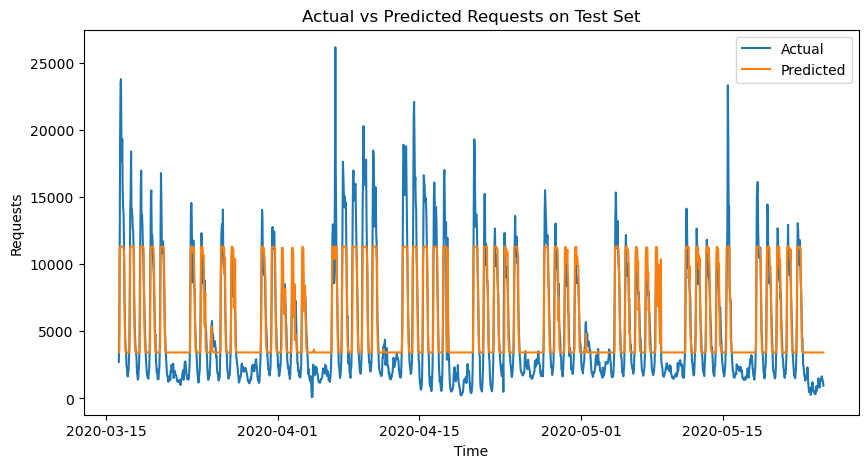

In [17]:
# Evaluate the model on the test data
model.eval()
test_loss = 0.0
test_predictions = []
test_targets = []
with torch.no_grad():
    for x, y in test_dataloader:
        x = x.unsqueeze(-1)  # Add a dimension for input features
        y = y.unsqueeze(-1)  # Add a dimension for output features

        output = model(x)
        loss = criterion(output, y)
        test_loss += loss.item()

        test_predictions.append(output.numpy())
        test_targets.append(y.numpy())

test_loss /= len(test_dataloader)
print(f'Test Loss: {test_loss:.4f}')

# Concatenate predictions and targets
test_predictions = np.concatenate(test_predictions).flatten()
test_targets = np.concatenate(test_targets).flatten()

# Convert predictions and targets back to original scale
test_predictions_original = scaler.inverse_transform(test_predictions.reshape(-1, 1)).flatten()
test_targets_original = scaler.inverse_transform(test_targets.reshape(-1, 1)).flatten()

# Store datetime values corresponding to test data
test_datetimes = data['Timestamp'].values[train_size + val_size + sequence_length:]

# Ensure the datetime index matches the length of the test set
adjusted_length = min(len(test_datetimes), len(test_targets_original))
adjusted_test_datetimes = test_datetimes[:adjusted_length]
test_targets_original = test_targets_original[:adjusted_length]
test_predictions_original = test_predictions_original[:adjusted_length]

print(f"Length of test_datetimes: {len(test_datetimes)}")
print(f"Length of test_targets_original: {len(test_targets_original)}")
print(f"Length of test_predictions_original: {len(test_predictions_original)}")
print(f"Adjusted length of test_datetimes: {len(adjusted_test_datetimes)}")

# Plot the test results with datetime values
plt.figure(figsize=(10, 5))
plt.plot(adjusted_test_datetimes, test_targets_original, label='Actual')
plt.plot(adjusted_test_datetimes, test_predictions_original, label='Predicted')
plt.xlabel('Time')
plt.ylabel('Requests')
plt.title('Actual vs Predicted Requests on Test Set')
plt.legend()
plt.show()

In [18]:
# Mean Squared Error (MSE)
mse = mean_squared_error(test_targets, test_predictions)
print(f'Mean Squared Error (MSE): {mse:.4f}')

# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error (RMSE): {rmse:.4f}')

# R-squared (R²)
r2 = r2_score(test_targets, test_predictions)
print(f'R-squared (R²): {r2:.4f}')


Mean Squared Error (MSE): 0.0691
Root Mean Squared Error (RMSE): 0.2628
R-squared (R²): 0.7898


### BILSTM model

Epoch [1/20], Train Loss: 0.6380, Validation Loss: 0.2778
Epoch [2/20], Train Loss: 0.5671, Validation Loss: 0.2768
Epoch [3/20], Train Loss: 0.5717, Validation Loss: 0.2719
Epoch [4/20], Train Loss: 0.5573, Validation Loss: 0.2747
Epoch [5/20], Train Loss: 0.5558, Validation Loss: 0.2749
Epoch [6/20], Train Loss: 0.5556, Validation Loss: 0.2727
Epoch [7/20], Train Loss: 0.5555, Validation Loss: 0.2737
Epoch [8/20], Train Loss: 0.5559, Validation Loss: 0.2729
Epoch [9/20], Train Loss: 0.5553, Validation Loss: 0.2828
Epoch [10/20], Train Loss: 0.5550, Validation Loss: 0.2720
Epoch [11/20], Train Loss: 0.5553, Validation Loss: 0.2713
Epoch [12/20], Train Loss: 0.5548, Validation Loss: 0.2728
Epoch [13/20], Train Loss: 0.5542, Validation Loss: 0.2724
Epoch [14/20], Train Loss: 0.5661, Validation Loss: 0.2705
Epoch [15/20], Train Loss: 0.5548, Validation Loss: 0.2743
Epoch [16/20], Train Loss: 0.5545, Validation Loss: 0.2716
Epoch [17/20], Train Loss: 0.5539, Validation Loss: 0.2700
Epoch 

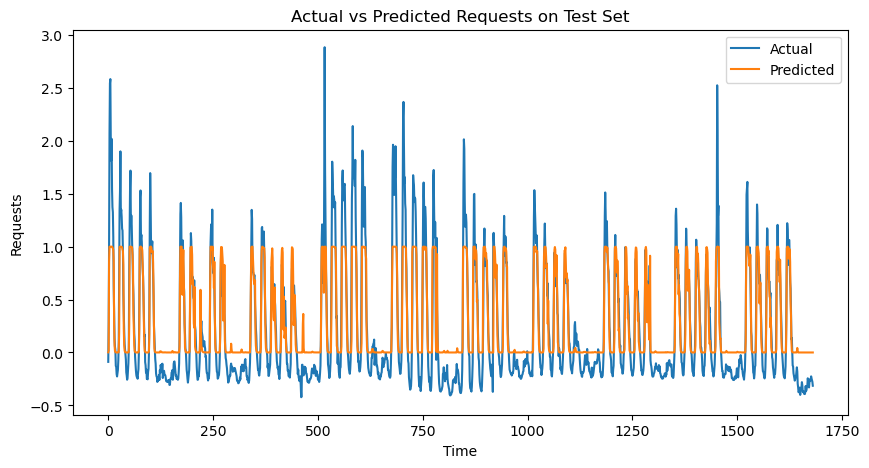

In [19]:
# Define the Bi-LSTM Model class
class BiLSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim, dropout=0.2):
        super(BiLSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)  # hidden_dim * 2 for bidirectional
        self.dropout = nn.Dropout(dropout)
        self.activation = nn.Sigmoid()

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        lstm_out = self.dropout(lstm_out[:, -1, :])  # Get the last output of the sequence
        out = self.fc(lstm_out)
        out = self.activation(out)
        return out

# Initialize model parameters
input_dim = 1
hidden_dim = 20
num_layers = 2
output_dim = 1
dropout = 0.2

model = BiLSTMModel(input_dim, hidden_dim, num_layers, output_dim, dropout)

# Training configurations
num_epochs = 20
learning_rate = 0.001

criterion = nn.MSELoss()
optimizer = optim.RMSprop(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for x, y in train_dataloader:
        x = x.unsqueeze(-1)  # Add a dimension for input features
        y = y.unsqueeze(-1)  # Add a dimension for output features

        optimizer.zero_grad()
        output = model(x)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_dataloader)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for x, y in val_dataloader:
            x = x.unsqueeze(-1)  # Add a dimension for input features
            y = y.unsqueeze(-1)  # Add a dimension for output features

            output = model(x)
            loss = criterion(output, y)

            val_loss += loss.item()

    val_loss /= len(val_dataloader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')

# Evaluate the model on the test data
model.eval()
test_loss = 0.0
test_predictions = []
test_targets = []
with torch.no_grad():
    for x, y in test_dataloader:
        x = x.unsqueeze(-1)  # Add a dimension for input features
        y = y.unsqueeze(-1)  # Add a dimension for output features

        output = model(x)
        loss = criterion(output, y)
        test_loss += loss.item()

        test_predictions.append(output.numpy())
        test_targets.append(y.numpy())

test_loss /= len(test_dataloader)
print(f'Test Loss: {test_loss:.4f}')

# Plot the test results
test_predictions = np.concatenate(test_predictions)
test_targets = np.concatenate(test_targets)

plt.figure(figsize=(10, 5))
plt.plot(test_targets, label='Actual')
plt.plot(test_predictions, label='Predicted')
plt.xlabel('Time')
plt.ylabel('Requests')
plt.title('Actual vs Predicted Requests on Test Set')
plt.legend()
plt.show()

In [20]:
# Mean Squared Error (MSE)
mse = mean_squared_error(test_targets, test_predictions)
print(f'Mean Squared Error (MSE): {mse:.4f}')

# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error (RMSE): {rmse:.4f}')

# R-squared (R²)
r2 = r2_score(test_targets, test_predictions)
print(f'R-squared (R²): {r2:.4f}')


Mean Squared Error (MSE): 0.0689
Root Mean Squared Error (RMSE): 0.2624
R-squared (R²): 0.7905


# Random Forests

Validation MSE: 0.0478
Test MSE: 0.0534
Test RMSE: 0.2312
Test R-squared: 0.8305


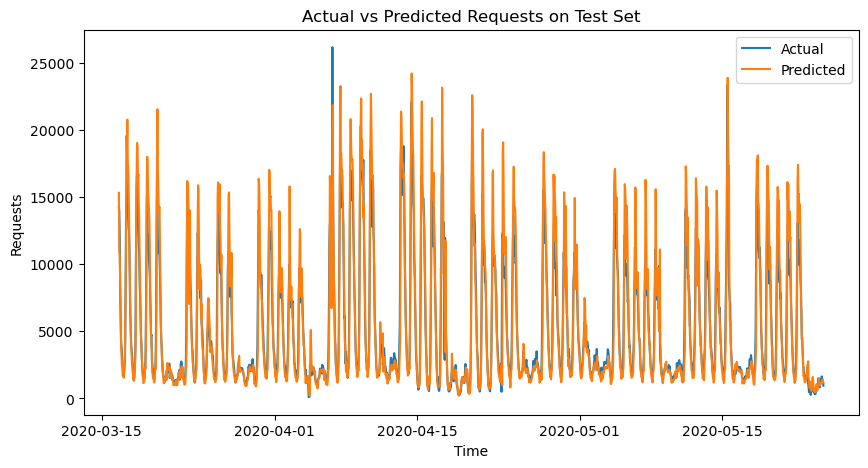

In [21]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor

# Prepare the data for Random Forest
def create_sequences(data, sequence_length):
    xs, ys = [], []
    for i in range(len(data) - sequence_length):
        x = data[i:i + sequence_length]
        y = data[i + sequence_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

sequence_length = 20
X_train, y_train = create_sequences(train_data, sequence_length)
X_val, y_val = create_sequences(val_data, sequence_length)
X_test, y_test = create_sequences(test_data, sequence_length)

# Train the Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Evaluate on validation set
val_predictions = rf_model.predict(X_val)
val_mse = mean_squared_error(y_val, val_predictions)
print(f'Validation MSE: {val_mse:.4f}')

# Evaluate on test set
test_predictions = rf_model.predict(X_test)
test_mse = mean_squared_error(y_test, test_predictions)
print(f'Test MSE: {test_mse:.4f}')

# Calculate RMSE
test_rmse = np.sqrt(test_mse)
print(f'Test RMSE: {test_rmse:.4f}')

# Calculate R-squared
test_r2 = r2_score(y_test, test_predictions)
print(f'Test R-squared: {test_r2:.4f}')

# Convert predictions and targets back to original scale
y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
test_predictions_original = scaler.inverse_transform(test_predictions.reshape(-1, 1)).flatten()

# Store datetime values corresponding to test data
test_datetimes = data['Timestamp'].values[train_size + val_size + sequence_length:train_size + val_size + sequence_length + len(y_test_original)]

# Ensure the datetime index matches the length of the test set
adjusted_test_datetimes = test_datetimes[:len(y_test_original)]

# Plot the test results with datetime values
plt.figure(figsize=(10, 5))
plt.plot(adjusted_test_datetimes, y_test_original, label='Actual')
plt.plot(adjusted_test_datetimes, test_predictions_original, label='Predicted')
plt.xlabel('Time')
plt.ylabel('Requests')
plt.title('Actual vs Predicted Requests on Test Set')
plt.legend()
plt.show()


### Decision Trees

Validation MSE: 0.0786
Test MSE: 0.0687
Test RMSE: 0.2622
Test R-squared: 0.7819


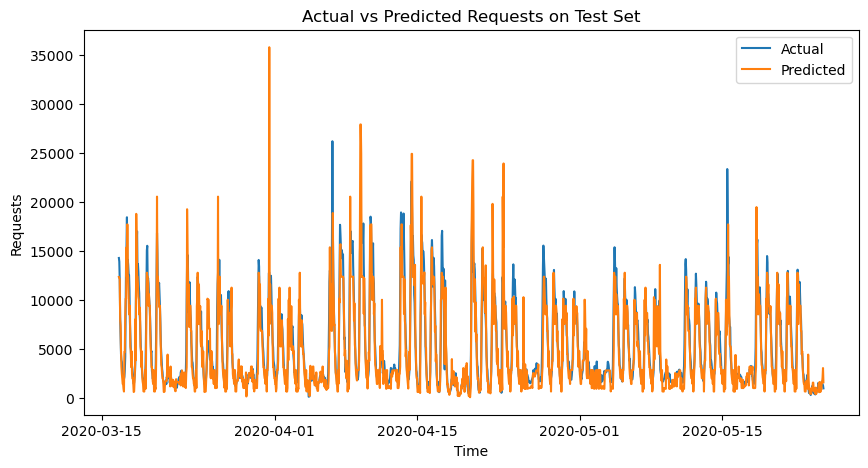

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Prepare the data for Decision Tree Regression
def create_sequences(data, sequence_length):
    xs, ys = [], []
    for i in range(len(data) - sequence_length):
        x = data[i:i + sequence_length]
        y = data[i + sequence_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

sequence_length = 20
X_train, y_train = create_sequences(train_data, sequence_length)
X_val, y_val = create_sequences(val_data, sequence_length)
X_test, y_test = create_sequences(test_data, sequence_length)

# Train the Decision Tree Regressor
dt_model = DecisionTreeRegressor(random_state=42)
dt_model.fit(X_train, y_train)

# Evaluate on validation set
val_predictions = dt_model.predict(X_val)
val_mse = mean_squared_error(y_val, val_predictions)
print(f'Validation MSE: {val_mse:.4f}')

# Evaluate on test set
test_predictions = dt_model.predict(X_test)
test_mse = mean_squared_error(y_test, test_predictions)
print(f'Test MSE: {test_mse:.4f}')

# Calculate RMSE
test_rmse = np.sqrt(test_mse)
print(f'Test RMSE: {test_rmse:.4f}')

# Calculate R-squared
test_r2 = r2_score(y_test, test_predictions)
print(f'Test R-squared: {test_r2:.4f}')

# Convert predictions and targets back to original scale
y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
test_predictions_original = scaler.inverse_transform(test_predictions.reshape(-1, 1)).flatten()

# Store datetime values corresponding to test data
test_datetimes = data['Timestamp'].values[train_size + val_size + sequence_length:train_size + val_size + sequence_length + len(y_test_original)]

# Ensure the datetime index matches the length of the test set
adjusted_test_datetimes = test_datetimes[:len(y_test_original)]

# Plot the test results with datetime values
plt.figure(figsize=(10, 5))
plt.plot(adjusted_test_datetimes, y_test_original, label='Actual')
plt.plot(adjusted_test_datetimes, test_predictions_original, label='Predicted')
plt.xlabel('Time')
plt.ylabel('Requests')
plt.title('Actual vs Predicted Requests on Test Set')
plt.legend()
plt.show()


Validation MSE: 0.0753
Test MSE: 0.0870
Test RMSE: 0.2950
Test R-squared: 0.7235


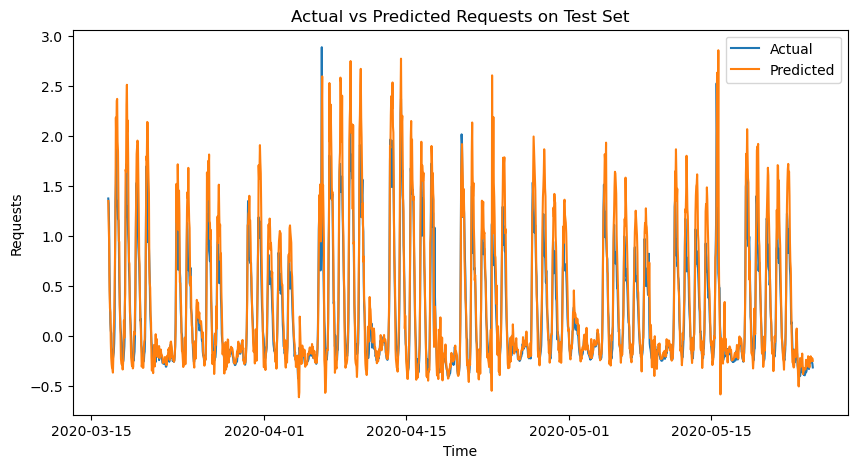

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

# Prepare the data for SVM Regression
def create_sequences(data, sequence_length):
    xs, ys = [], []
    for i in range(len(data) - sequence_length):
        x = data[i:i + sequence_length]
        y = data[i + sequence_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

sequence_length = 20
X_train, y_train = create_sequences(train_data, sequence_length)
X_val, y_val = create_sequences(val_data, sequence_length)
X_test, y_test = create_sequences(test_data, sequence_length)

# Initialize the StandardScaler
scaler_X = StandardScaler()
scaler_y = StandardScaler()

# Reshape the data for the scaler
y_train = y_train.reshape(-1, 1)
y_val = y_val.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

# Fit and transform the scaler on the training data
X_train = scaler_X.fit_transform(X_train)
y_train = scaler_y.fit_transform(y_train).flatten()

# Transform the validation and test data
X_val = scaler_X.transform(X_val)
y_val = scaler_y.transform(y_val).flatten()
X_test = scaler_X.transform(X_test)
y_test = scaler_y.transform(y_test).flatten()

# Train the Support Vector Regressor
svm_model = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=0.1)
svm_model.fit(X_train, y_train)

# Evaluate on validation set
val_predictions = svm_model.predict(X_val)
val_mse = mean_squared_error(y_val, val_predictions)
print(f'Validation MSE: {val_mse:.4f}')

# Evaluate on test set
test_predictions = svm_model.predict(X_test)
test_mse = mean_squared_error(y_test, test_predictions)
print(f'Test MSE: {test_mse:.4f}')

# Calculate RMSE
test_rmse = np.sqrt(test_mse)
print(f'Test RMSE: {test_rmse:.4f}')

# Calculate R-squared
test_r2 = r2_score(y_test, test_predictions)
print(f'Test R-squared: {test_r2:.4f}')

# Convert predictions and targets back to original scale
y_test_original = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()
test_predictions_original = scaler_y.inverse_transform(test_predictions.reshape(-1, 1)).flatten()

# Store datetime values corresponding to test data
test_datetimes = data['Timestamp'].values[train_size + val_size + sequence_length:train_size + val_size + sequence_length + len(y_test_original)]

# Ensure the datetime index matches the length of the test set
adjusted_test_datetimes = test_datetimes[:len(y_test_original)]

# Plot the test results with datetime values
plt.figure(figsize=(10, 5))
plt.plot(adjusted_test_datetimes, y_test_original, label='Actual')
plt.plot(adjusted_test_datetimes, test_predictions_original, label='Predicted')
plt.xlabel('Time')
plt.ylabel('Requests')
plt.title('Actual vs Predicted Requests on Test Set')
plt.legend()
plt.show()
